In [24]:
import pandas as pd
import numpy as np
import os
import sys
from scipy.interpolate import CubicSpline
import warnings

pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [25]:
# Read the CSV file
df_wind = pd.read_csv(os.path.join(os.getcwd(), '..', 'data', 'wind3.csv'))

# drop the columns that are not needed
# df_wind = df_wind.drop(columns=['SS_Price', 'boa_MWh', 'DA_Price', 'Wind_MWh_credit', 'dtm', 'MIP'])
df_wind = df_wind.drop(columns=['dtm', 'MIP', 'date_diff'])

# drop Wind_MW and rename Wind_MWh_credit to Wind_MW
df_wind = df_wind.drop(columns=['Wind_MW'])
df_wind = df_wind.rename(columns={'Wind_MWh_credit': 'Wind_MW'})

# to datetime
df_wind['reference_time'] = pd.to_datetime(df_wind['reference_time'])
df_wind['valid_time'] = pd.to_datetime(df_wind['valid_time'])

df_latest = df_wind.copy()
# drop everything after Jan 20, 2024
df_latest = df_latest[df_latest['valid_time'] < '2024-01-21']

# calculate the average of the two forecasts and drop the individual forecasts (except WindSpeed^3:100)
df_latest['WindSpeed^3:100_avg'] = (df_latest['WindSpeed^3:100_dwd'] + df_latest['WindSpeed^3:100_ncep']) / 2
df_latest['Temperature_avg'] = (df_latest['Temperature_dwd'] + df_latest['Temperature_ncep']) / 2
df_latest['RelativeHumidity_avg'] = (df_latest['RelativeHumidity_dwd'] + df_latest['RelativeHumidity_ncep']) / 2
df_latest['WindDirection:100_avg'] = (df_latest['WindDirection:100_dwd'] + df_latest['WindDirection:100_ncep']) / 2

df_latest = df_latest.drop(columns=['WindSpeed_dwd', 'WindSpeed_ncep', 'Temperature_dwd', 'Temperature_ncep', 'RelativeHumidity_dwd', 'RelativeHumidity_ncep', 'WindSpeed^3_dwd', 'WindSpeed^3_ncep', 'WindDirection_dwd', 'WindDirection_ncep', 'WindSpeed:100_dwd', 'WindSpeed:100_ncep', 'WindSpeed:100^3_dwd', 'WindSpeed:100^3_ncep', 'WindDirection:100_dwd', 'WindDirection:100_ncep'])

# remove ^3 from the column names
df_latest.columns = [col.replace('^3', '') for col in df_latest.columns]

# i. Calculate Power Forecast based on Physics

## 1. Calculate Air Density

In [26]:
# Constants
R_d = 287.05  # Specific gas constant for dry air (J/(kg·K))
R_v = 461.5   # Specific gas constant for water vapor (J/(kg·K))
p = 101325    # Standard atmospheric pressure in Pa

# Assuming df_latest is your original DataFrame and contains 'Temperature_dwd', 'RelativeHumidity_dwd', 'WindSpeed_dwd'
# Convert temperature from Celsius to Kelvin
df_latest['Temperature_K'] = df_latest['Temperature_avg'] + 273.15

# Calculate saturation vapor pressure (using temperature in Celsius), Tetens formula
e_s = 0.61078 * np.exp((17.27 * df_latest['Temperature_avg']) / (df_latest['Temperature_avg'] + 237.3))

# in pa
e_s = 1000 * e_s

# Calculate actual vapor pressure
e = df_latest['RelativeHumidity_avg'] / 100 * e_s

# Calculate air density (ρ) in kg/m³
df_latest['AirDensity'] = (p - e) / (R_d * df_latest['Temperature_K']) + (e / (R_v * df_latest['Temperature_K']))

## 2. Calculate Power based on Density and Wind Speed

In [27]:
def calculate_wind_generation(dataset, rotor_diameter = 154, efficiency = 0.31, limiter = 1, minimum_wind_speed = 3, maximum_wind_speed_for_operation = 25, add_opt = False):
    rotor_area = np.pi * (rotor_diameter / 2) ** 2  # in m²
    
    # turbine requires 3m/s to start rotating
    const_internal_friction_coefficient = 0.5 * 1.240 * rotor_area * 3**3 * efficiency * 174 / 1000000
    maximum_power_per_turbine = 7 # in MW

    # Calculate power output based on wind speed at 100m
    dataset['WindPower:100'] = 0.5 * dataset['AirDensity'] * rotor_area * dataset['WindSpeed:100_avg'] ** 3 * 174 / 1000000
    dataset[f'UsableWindPower{"_opt" if add_opt else ":100"}'] = np.minimum(dataset['WindPower:100'], maximum_power_per_turbine * 174 * limiter / efficiency)
    dataset[f'PowerOutput{"_opt" if add_opt else ""}'] = np.where((dataset['WindSpeed:100_avg'] >= minimum_wind_speed) & (dataset['WindSpeed:100_avg'] <= maximum_wind_speed_for_operation), (dataset['UsableWindPower:100'] * efficiency - const_internal_friction_coefficient) * 0.5, 0)

    return dataset

In [28]:
df_latest = calculate_wind_generation(df_latest)

# Absolute error
print('Mean Absolute error:', np.mean(np.abs(df_latest['Wind_MW'] - df_latest['PowerOutput'])))
# Initialize a list to collect the stats
stats_df = pd.DataFrame({'quantile': [], 'quantile_range': [], 'mean_absolute_error': [], 'mean_error': []})

# Mean absolute error in 10% quantiles
for q in np.arange(0.1, 1.1, 0.1):
    # Filter the DataFrame for each quantile range
    quantile_df = df_latest[(df_latest['Wind_MW'] < df_latest['Wind_MW'].quantile(q)) & (df_latest['Wind_MW'] >= df_latest['Wind_MW'].quantile(q - 0.1))]
    
    # Calculate the statistics
    quantile_stats = {
        'quantile': q,
        'quantile_range': f'{df_latest["Wind_MW"].quantile(q - 0.1):.1f} - {df_latest["Wind_MW"].quantile(q):.1f}',
        'mean_absolute_error': np.mean(np.abs(quantile_df['Wind_MW'] - quantile_df['PowerOutput'])),
        'mean_error': np.mean(quantile_df['Wind_MW'] - quantile_df['PowerOutput']),
    }
    
    # Append to the list
    stats_df.loc[len(stats_df)] = quantile_stats

# Display the DataFrame
stats_df

Mean Absolute error: 62.843102434485324


,quantile,quantile_range,mean_absolute_error,mean_error
0,0.1,0.0 - 9.6,25.514406,-24.314613
1,0.2,9.6 - 46.2,30.900876,-14.804647
2,0.3,46.2 - 99.8,47.306723,-8.378162
3,0.4,99.8 - 171.5,62.998945,0.773659
4,0.5,171.5 - 262.0,85.293963,15.682970
5,0.6,262.0 - 378.5,107.337344,30.905893
6,0.7,378.5 - 501.5,118.343157,37.558200
7,0.8,501.5 - 555.5,82.182955,-1.415686
8,0.9,555.5 - 577.7,46.329869,-9.212640
9,1.0,577.7 - 602.2,22.236415,-3.205679


## 3. Find optimal $\eta$ to update the approximation of the turbine efficiency

In [29]:
errors = {}
for efficiency in np.arange(0.28, 0.35, 0.001):
    for limiter in np.arange(0.9, 1.01, 0.01):
        df_tmp = calculate_wind_generation(df_latest, efficiency=efficiency, limiter=limiter)
        mean_abs_error = np.mean(np.abs(df_tmp['Wind_MW'] - df_tmp['PowerOutput']))
        mean_error = np.mean(df_tmp['Wind_MW'] - df_tmp['PowerOutput'])
        errors[(efficiency.round(3), limiter.round(2))] = [mean_abs_error, mean_error]

In [30]:
# Find the minimum error
min_error = min(errors, key=lambda x: errors[x])
print(f'Minimum mean absolute error: {errors[min_error][0]:.2f} with efficiency={min_error}')
print(f'Mean error: {errors[min_error][1]:.2f}')

Minimum mean absolute error: 57.35 with efficiency=(0.337, 0.94)
Mean error: 2.28


In [31]:
efficiency = min_error[0]
limiter = min_error[1]

df_latest = calculate_wind_generation(df_latest, efficiency=efficiency, limiter=limiter, add_opt = True)

In [32]:
# Update stats_df using optimal values
for q in np.arange(0.1, 1.1, 0.1):
    quantile_df = df_latest[(df_latest['Wind_MW'] < df_latest['Wind_MW'].quantile(q)) & (df_latest['Wind_MW'] >= df_latest['Wind_MW'].quantile(q - 0.1))]
    quantile_row = {
        'quantile': q,
        'mean_absolute_error_opt': np.mean(np.abs(quantile_df['Wind_MW'] - quantile_df['PowerOutput_opt'])),
        'mean_error_opt': np.mean(quantile_df['Wind_MW'] - quantile_df['PowerOutput_opt'])
    }
    stats_df.loc[stats_df['quantile'] == q, 'mean_absolute_error_opt'] = quantile_row['mean_absolute_error_opt']
    stats_df.loc[stats_df['quantile'] == q, 'mean_error_opt'] = quantile_row['mean_error_opt']

stats_df

,quantile,quantile_range,mean_absolute_error,mean_error,mean_absolute_error_opt,mean_error_opt
0,0.1,0.0 - 9.6,25.514406,-24.314613,26.842748,-25.663666
1,0.2,9.6 - 46.2,30.900876,-14.804647,33.306089,-18.252954
2,0.3,46.2 - 99.8,47.306723,-8.378162,49.970216,-14.739745
3,0.4,99.8 - 171.5,62.998945,0.773659,66.056263,-9.992842
4,0.5,171.5 - 262.0,85.293963,15.682970,86.455942,0.195872
5,0.6,262.0 - 378.5,107.337344,30.905893,105.517940,10.227615
6,0.7,378.5 - 501.5,118.343157,37.558200,109.976937,17.267200
7,0.8,501.5 - 555.5,82.182955,-1.415686,63.135889,-0.562649
8,0.9,555.5 - 577.7,46.329869,-9.212640,24.456689,3.778753
9,1.0,577.7 - 602.2,22.236415,-3.205679,14.769889,14.692558


## 3. Make Forecast more accurate using smoothing of windspeed between datapoints

In [33]:
# Iterate over each reference_time
df_latest['PowerOutput_smoothed'] = 0.0
rotor_diameter = 154
minimum_wind_speed = 3
maximum_wind_speed_for_operation = 25
rotor_area = np.pi * (rotor_diameter / 2) ** 2
const_internal_friction_coefficient = 0.5 * 1.240 * rotor_area * 3**3 * efficiency * 174 / 1000000
maximum_power_per_turbine = 7 # in MW

for reference_time, group in df_latest.groupby('reference_time'):

    # Get the valid_times and corresponding wind speeds for this reference_time
    valid_times = group['valid_time'].values
    wind_speeds = group['WindSpeed:100_avg'].values
    actual_generation = group['Wind_MW'].values
    
    # Convert valid_times to seconds for interpolation
    valid_times_in_seconds = (valid_times - valid_times[0]).astype('timedelta64[m]').astype(int) * 60  # seconds
    
    if len(valid_times) < 2:
        wind_power = 0.5 * group['AirDensity'].iloc[0] * rotor_area * avg_cubed_wind * 174 / 1000000
        usable_wind_power = min(wind_power, 7 * 174 * limiter / efficiency)
        power_output = (usable_wind_power * efficiency - const_internal_friction_coefficient)*0.5 if (group['WindSpeed:100_avg'].iloc[0] >= minimum_wind_speed) and (group['WindSpeed:100_avg'].iloc[0] <= maximum_wind_speed_for_operation) else 0

        # Update PowerOutput
        df_latest.loc[(df_latest['reference_time'] == reference_time) & (df_latest['valid_time'] == valid_times[0]), 'PowerOutput_smoothed'] = power_output
        continue
    # Perform cubic spline interpolation for 1-minute intervals
    wind_speed_spline = CubicSpline(valid_times_in_seconds, wind_speeds)
    
    # Generate 1-minute intervals for the valid_time range
    for i in range(len(valid_times) - 1):
        t_start = valid_times_in_seconds[i]
        t_end = valid_times_in_seconds[i + 1]
        
        # Generate time points at 1-minute intervals within this 30-minute window
        times_1min = np.arange(t_start, t_end, 60)
        
        # Interpolate wind speeds at 1-minute intervals
        interpolated_wind_speeds = wind_speed_spline(times_1min)
        
        # Calculate the average wind power using the cubed wind speeds, reduce speeds <3ms to 0
        avg_cubed_wind = np.mean(np.where((interpolated_wind_speeds >= 3) & (interpolated_wind_speeds <= 25), interpolated_wind_speeds, 0) ** 3)
        avg_cubed_wind = np.mean(interpolated_wind_speeds ** 3)
        # get frac with windspeed > 3 and < 25
        frac_generation = np.mean(np.where((interpolated_wind_speeds >= 3) & (interpolated_wind_speeds <= 25), 1, 0))
        
        # Calculate wind power and apply limits for each interval
        wind_power = 0.5 * group['AirDensity'].iloc[i] * rotor_area * avg_cubed_wind * 174 / 1000000
        usable_wind_power = min(wind_power, 7 * 174 * limiter / efficiency)
        
        # Calculate final power output based on cut-in, cut-out wind speeds and efficiency
        power_output = max(0, (usable_wind_power * efficiency - const_internal_friction_coefficient * frac_generation)*0.5)
        
        # Update PowerOutput
        valid_time = pd.to_datetime(valid_times[i])
        df_latest.loc[(df_latest['reference_time'] == reference_time) & (df_latest['valid_time'] == valid_time), 'PowerOutput_smoothed'] = power_output

In [34]:
# Absolute error
print('Mean Absolute error:', np.mean(np.abs(df_latest['Wind_MW'] - df_latest['PowerOutput_smoothed'])))
# Mean absolute error in 10% quantiles
for q in np.arange(0.1, 1.1, 0.1):
    quantile_df = df_latest[(df_latest['Wind_MW'] < df_latest['Wind_MW'].quantile(q)) & (df_latest['Wind_MW'] >= df_latest['Wind_MW'].quantile(q - 0.1))]
    quantile_row = {
        'quantile': q,
        'mean_absolute_error_new': np.mean(np.abs(quantile_df['Wind_MW'] - quantile_df['PowerOutput_smoothed'])),
        'mean_error_new': np.mean(quantile_df['Wind_MW'] - quantile_df['PowerOutput_smoothed'])
    }
    stats_df.loc[stats_df['quantile'] == q, 'mean_absolute_error_new'] = quantile_row['mean_absolute_error_new']
    stats_df.loc[stats_df['quantile'] == q, 'mean_error_new'] = quantile_row['mean_error_new']

stats_df


Mean Absolute error: 61.33098927672748


,quantile,quantile_range,mean_absolute_error,mean_error,mean_absolute_error_opt,mean_error_opt,mean_absolute_error_new,mean_error_new
0,0.1,0.0 - 9.6,25.514406,-24.314613,26.842748,-25.663666,27.478584,-26.910848
1,0.2,9.6 - 46.2,30.900876,-14.804647,33.306089,-18.252954,32.405707,-17.350987
2,0.3,46.2 - 99.8,47.306723,-8.378162,49.970216,-14.739745,50.123879,-12.913919
3,0.4,99.8 - 171.5,62.998945,0.773659,66.056263,-9.992842,66.835262,-6.501396
4,0.5,171.5 - 262.0,85.293963,15.682970,86.455942,0.195872,87.734394,4.776762
5,0.6,262.0 - 378.5,107.337344,30.905893,105.517940,10.227615,107.613117,17.346325
6,0.7,378.5 - 501.5,118.343157,37.558200,109.976937,17.267200,110.539194,26.395263
7,0.8,501.5 - 555.5,82.182955,-1.415686,63.135889,-0.562649,60.843572,19.587840
8,0.9,555.5 - 577.7,46.329869,-9.212640,24.456689,3.778753,29.888094,27.906870
9,1.0,577.7 - 602.2,22.236415,-3.205679,14.769889,14.692558,39.853724,39.853724


## => It got worse????

In [35]:
df_latest.columns

Index(['reference_time', 'valid_time', 'WindSpeed:100_dwd',
       'WindSpeed:100_ncep', 'SS_Price', 'boa_MWh', 'DA_Price', 'Wind_MW',
       'WindSpeed:100_avg', 'Temperature_avg', 'RelativeHumidity_avg',
       'WindDirection:100_avg', 'Temperature_K', 'AirDensity', 'WindPower:100',
       'UsableWindPower:100', 'PowerOutput', 'UsableWindPower_opt',
       'PowerOutput_opt', 'PowerOutput_smoothed'],
      dtype='object')

# ii. Prediciting the optimal submision value by creating custom ML models

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# add three lag features for WindSpeed:100_dwd
df_latest['WindSpeed:100_dwd_lag1'] = df_latest['WindSpeed:100_dwd'].shift(1)
df_latest['WindSpeed:100_dwd_lag2'] = df_latest['WindSpeed:100_dwd'].shift(2)
df_latest['WindSpeed:100_dwd_lag3'] = df_latest['WindSpeed:100_dwd'].shift(3)

# df_latest['residual'] = df_latest['Wind_MW'] - df_latest['PowerOutput_opt']

df_latest = df_latest.dropna()

# select features for models
data = df_latest[['WindSpeed:100_dwd', 'Temperature_avg', 'RelativeHumidity_avg', 'AirDensity', 'WindSpeed:100_dwd_lag1', 'WindSpeed:100_dwd_lag2', 'WindSpeed:100_dwd_lag3', 'PowerOutput_opt', 'DA_Price', 'SS_Price', 'Wind_MW', 'UsableWindPower_opt']].copy()

In [44]:
# Device Selection
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA GPU")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using M1/M2 GPU with MPS")
else:
    device = torch.device("cpu")
    print("Using CPU")


Using M1/M2 GPU with MPS


## a) MLP

Epoch [1/100], Training Loss: 3552.2966, Test Loss: 2465.4149
Epoch [2/100], Training Loss: 3312.6379, Test Loss: 2467.9833
Epoch [3/100], Training Loss: 3306.7273, Test Loss: 2520.3850
Epoch [4/100], Training Loss: 3291.3243, Test Loss: 2482.3114
Epoch [5/100], Training Loss: 3262.2066, Test Loss: 2481.1506
Epoch [6/100], Training Loss: 3254.1282, Test Loss: 2499.3414
Epoch [7/100], Training Loss: 3255.8218, Test Loss: 2474.9142
Epoch [8/100], Training Loss: 3251.3171, Test Loss: 2535.8046
Epoch [9/100], Training Loss: 3238.1504, Test Loss: 2441.5781
Epoch [10/100], Training Loss: 3230.3891, Test Loss: 2492.3963
Epoch [11/100], Training Loss: 3231.5079, Test Loss: 2494.1999
Epoch [12/100], Training Loss: 3217.1676, Test Loss: 2482.9152
Epoch [13/100], Training Loss: 3216.0554, Test Loss: 2497.2880
Epoch [14/100], Training Loss: 3215.4783, Test Loss: 2464.6028
Epoch [15/100], Training Loss: 3190.2053, Test Loss: 2542.5805
Epoch [16/100], Training Loss: 3208.9418, Test Loss: 2459.4869
E

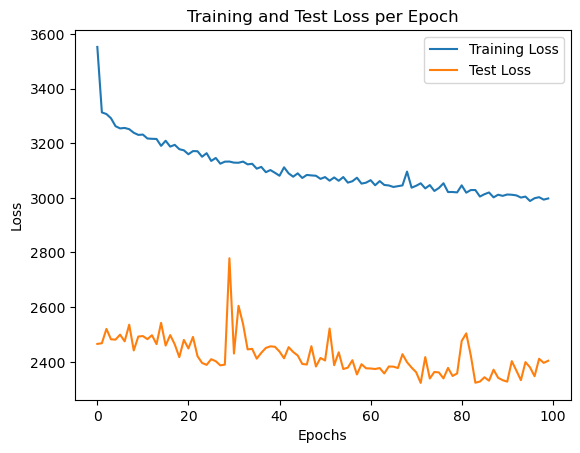

In [45]:
# Dataset class for PyTorch DataLoader
class WindFarmDataset(Dataset):
    def __init__(self, data):
        self.features = data[['WindSpeed:100_dwd', 'Temperature_avg', 'RelativeHumidity_avg', 
                              'AirDensity', 'UsableWindPower_opt', 'WindSpeed:100_dwd_lag1', 
                              'WindSpeed:100_dwd_lag2', 'WindSpeed:100_dwd_lag3', 
                              'PowerOutput_opt', 'DA_Price', 'SS_Price']].values
        self.actual = data['Wind_MW'].values
        self.dap = data['DA_Price'].values
        self.ssp = data['SS_Price'].values

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return {
            'features': torch.tensor(self.features[idx], dtype=torch.float32),
            'actual': torch.tensor(self.actual[idx], dtype=torch.float32),
            'dap': torch.tensor(self.dap[idx], dtype=torch.float32),
            'ssp': torch.tensor(self.ssp[idx], dtype=torch.float32)
        }

# Custom Loss Function based on Revenue Difference
class RevenueLoss(nn.Module):
    def __init__(self):
        super(RevenueLoss, self).__init__()

    def forward(self, prediction, actual, dap, ssp):
        trade = prediction
        optimal_revenue = (actual * dap)
        predicted_revenue = trade * dap + (actual - trade) * (ssp - 0.07 * (actual - trade))
        loss = torch.mean(torch.abs(optimal_revenue - predicted_revenue))
        return loss

# Define the Neural Network Model
class TradeForecastModel(nn.Module):
    def __init__(self, input_dim):
        super(TradeForecastModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 1)  # Output layer for Trade forecast
        )

    def forward(self, x):
        return self.network(x)

def evaluate_model(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            features = batch['features'].to(device)
            actual = batch['actual'].to(device)
            dap = batch['dap'].to(device)
            ssp = batch['ssp'].to(device)
            predictions = model(features).squeeze()
            loss = criterion(predictions, actual, dap, ssp)
            total_loss += loss.item()
    return total_loss / len(loader)


# Initialize dataset and dataloader
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)
train_dataset = WindFarmDataset(train_data)
test_dataset = WindFarmDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
input_dim = train_dataset.features.shape[1]
model = TradeForecastModel(input_dim=input_dim).to(device)
criterion = RevenueLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 100
train_losses, test_losses = [], []
for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    # Training step
    for batch in train_loader:
        features = batch['features'].to(device)
        actual = batch['actual'].to(device)
        dap = batch['dap'].to(device)
        ssp = batch['ssp'].to(device)

        # Forward pass
        optimizer.zero_grad()
        predictions = model(features).squeeze()
        
        # Calculate loss
        loss = criterion(predictions, actual, dap, ssp)
        total_train_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    # Average training loss
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Evaluation on test data
    avg_test_loss = evaluate_model(model, test_loader, criterion)
    test_losses.append(avg_test_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss per Epoch')
plt.show()

## b) LSTM

In [42]:
# Dataset class for PyTorch DataLoader
class WindFarmDataset(Dataset):
    def __init__(self, data, seq_len=5):
        self.data = data
        self.seq_len = seq_len
        self.features = data[['WindSpeed:100_dwd', 'Temperature_avg', 'RelativeHumidity_avg',
                              'AirDensity', 'UsableWindPower_opt', 'WindSpeed:100_dwd_lag1',
                              'WindSpeed:100_dwd_lag2', 'WindSpeed:100_dwd_lag3',
                              'PowerOutput_opt', 'DA_Price', 'SS_Price']].values
        self.actual = data['Wind_MW'].values

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        return {
            'features': torch.tensor(self.features[idx:idx + self.seq_len], dtype=torch.float32),
            'actual': torch.tensor(self.actual[idx + self.seq_len], dtype=torch.float32),
            'dap': torch.tensor(self.data['DA_Price'].iloc[idx + self.seq_len], dtype=torch.float32),
            'ssp': torch.tensor(self.data['SS_Price'].iloc[idx + self.seq_len], dtype=torch.float32)
        }

# Custom Revenue-Based Loss Function
class RevenueLoss(nn.Module):
    def __init__(self):
        super(RevenueLoss, self).__init__()

    def forward(self, prediction, actual, dap, ssp):
        trade = prediction
        optimal_revenue = (actual * dap)
        predicted_revenue = trade * dap + (actual - trade) * (ssp - 0.07 * (actual - trade))
        loss = torch.mean(torch.abs(optimal_revenue - predicted_revenue))
        return loss

# Define the LSTM Model
class TradeForecastLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(TradeForecastLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return out

# Initialize dataset and dataloader
seq_len = 5  # Define sequence length (number of time steps to look back)
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)
train_dataset = WindFarmDataset(train_data, seq_len=seq_len)
test_dataset = WindFarmDataset(test_data, seq_len=seq_len)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
input_dim = train_dataset.features.shape[1]
model = TradeForecastLSTM(input_dim=input_dim)
criterion = RevenueLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 50
train_losses, test_losses = [], []
for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    # Training step
    for batch in train_loader:
        features = batch['features']
        actual = batch['actual']
        dap = batch['dap']
        ssp = batch['ssp']

        # Forward pass
        optimizer.zero_grad()
        predictions = model(features).squeeze()
        
        # Calculate loss
        loss = criterion(predictions, actual, dap, ssp)
        total_train_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    # Average training loss
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Evaluation on test data
    avg_test_loss = evaluate_model(model, test_loader, criterion)
    test_losses.append(avg_test_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")


Epoch [1/50], Training Loss: 15048.5314, Test Loss: 9257.6907
Epoch [2/50], Training Loss: 11784.7488, Test Loss: 7307.1969
Epoch [3/50], Training Loss: 9522.0497, Test Loss: 5844.5422
Epoch [4/50], Training Loss: 7771.7466, Test Loss: 4785.3384
Epoch [5/50], Training Loss: 6378.3544, Test Loss: 3918.6109
Epoch [6/50], Training Loss: 5286.0491, Test Loss: 3546.8395
Epoch [7/50], Training Loss: 4491.2803, Test Loss: 3040.3338
Epoch [8/50], Training Loss: 3932.9807, Test Loss: 2950.0082
Epoch [9/50], Training Loss: 3708.2993, Test Loss: 2971.4297
Epoch [10/50], Training Loss: 3612.6964, Test Loss: 2887.5316
Epoch [11/50], Training Loss: 3575.7437, Test Loss: 2756.3835
Epoch [12/50], Training Loss: 3568.1510, Test Loss: 2671.7710
Epoch [13/50], Training Loss: 3561.7828, Test Loss: 2851.4386
Epoch [14/50], Training Loss: 3568.9164, Test Loss: 2688.9486
Epoch [15/50], Training Loss: 3610.0074, Test Loss: 2823.0074
Epoch [16/50], Training Loss: 3600.4437, Test Loss: 2834.0764
Epoch [17/50], 

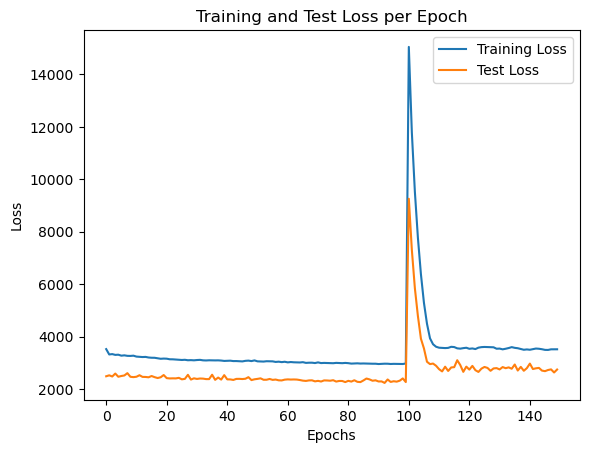

In [43]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss per Epoch')
plt.show()

# ii. Modeling the residium 

# Training quantile Models

## GradientBoostingRegressor

In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor

def train_gbr_model_quantiles(dataset, residual = True, include_calculation_features = False, eval = False, shuffle = False, split = 0.2, name = None):
    # Define the features (X) and the target (y)
    X = dataset[['WindSpeed:100_dwd', 'Temperature_avg', 'RelativeHumidity_avg', 'AirDensity', 'WindSpeed:100_dwd_lag1', 'WindSpeed:100_dwd_lag2', 'WindSpeed:100_dwd_lag3']]
    if include_calculation_features and not residual:
        X['PowerOutput_opt'] = dataset['PowerOutput_opt']
        X['UsableWindPower_opt'] = dataset['UsableWindPower_opt']
    if residual:
        X['UsableWindPower_opt'] = dataset['UsableWindPower_opt']
    y = dataset['residual'] if residual else dataset['Wind_MW']

    # Split the data into training and test sets
    if split > 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=42, shuffle=shuffle)
    else:
        X_train, y_train = X, y

    # Define the quantiles we want to model
    quantiles = np.arange(0.1, 1.0, 0.1)

    # Dictionary to hold the best models for each quantile
    best_models = {}

    # Loop over each quantile and train a model
    for quantile in quantiles:
        print(f"Training model for {quantile * 100:.0f}% quantile...")
        
        # Initialize the Gradient Boosting Regressor with the quantile loss
        gbr = HistGradientBoostingRegressor(loss='quantile', quantile=quantile, random_state=42)
        
        # Define the parameter grid for hyperparameter tuning
        param_grid = {
            'learning_rate': [0.01, 0.1],  # Controls the step size in each boosting step
            'max_iter': [300, 500],  # Number of boosting rounds
            'max_depth': [3, 5, 7],  # Maximum depth of the trees
            'min_samples_leaf': [1, 5, 10],  # Minimum number of samples required to be at a leaf node
        }

        # Custom scoring function for quantile regression (Pinball loss)
        def pinball_loss(y_true, y_pred):
            delta = y_true - y_pred
            return np.mean(np.maximum(quantile * delta, (quantile - 1) * delta))
        
        pinball_scorer = make_scorer(pinball_loss, greater_is_better=False)
        
        # Initialize GridSearchCV for hyperparameter tuning
        grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1, scoring=pinball_scorer)
        
        # Fit the model to the training data
        grid_search.fit(X_train, y_train)
        
        # Store the best model for this quantiles
        best_models[quantile] = grid_search.best_estimator_
        
        print(f"Best parameters for {quantile * 100:.0f}% quantile: {grid_search.best_params_}")

    if eval and split > 0:
        # Loop over each quantile to evaluate the models
        for quantile, model in best_models.items():
            # Predict the residuals for the test set
            y_pred = model.predict(X_test)
            
            # Calculate the evaluation metrics
            me = np.mean(y_test - y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            pinball = pinball_loss(y_test, y_pred)
            
            print(f"Evaluation for {quantile * 100:.0f}% quantile:")
            print(f"Mean Error (ME): {me:.3f}")
            print(f"Mean Absolute Error (MAE): {mae:.3f}")
            print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
            print(f"Pinball Loss: {pinball:.3f}")

            # compare to training data
            y_pred_train = model.predict(X_train)
            me = np.mean(y_train - y_pred_train)
            mae = mean_absolute_error(y_train, y_pred_train)
            rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
            pinball = pinball_loss(y_train, y_pred_train)

            print(f"\nTraining data:")
            print(f"Mean Error (ME): {me:.3f}")
            print(f"Mean Absolute Error (MAE): {mae:.3f}")
            print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
            print(f"Pinball Loss: {pinball:.3f}")
            print("-" * 40)

    for quantile, model in best_models.items():
        joblib.dump(model, os.path.join(os.getcwd(), 'models', f'gbr_quantile_{quantile:.1f}{"_" + name if name is not None else ""}_res-{residual}_calc-{include_calculation_features}.pkl'))
    
    return best_models



In [43]:
best_models_gbr = train_gbr_model_quantiles(df_latest, eval=True, )

Training model for 10% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 10% quantile: {'learning_rate': 0.01, 'max_depth': 5, 'max_iter': 500, 'min_samples_leaf': 10}
Training model for 20% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 20% quantile: {'learning_rate': 0.01, 'max_depth': 7, 'max_iter': 500, 'min_samples_leaf': 10}
Training model for 30% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 30% quantile: {'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 500, 'min_samples_leaf': 10}
Training model for 40% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 40% quantile: {'learning_rate': 0.01, 'max_depth': 3, 'max_iter': 300, 'min_samples_leaf': 1}
Training model for 50% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 50% quantile: {'learning_rate': 0.01,

# XGBoost

In [44]:
def train_xgb_model_quantiles(dataset, residual = True, include_calculation_features = False, eval = False, shuffle = False, split = 0.2):
    # Define the features (X) and the target (y)
    X = dataset[['WindSpeed:100_dwd', 'Temperature_avg', 'RelativeHumidity_avg', 'AirDensity', 'WindSpeed:100_dwd_lag1', 'WindSpeed:100_dwd_lag2', 'WindSpeed:100_dwd_lag3']]
    if include_calculation_features and not residual:
        X['PowerOutput_opt'] = dataset['PowerOutput_opt']
        X['UsableWindPower_opt'] = dataset['UsableWindPower_opt']
    if residual:
        X['UsableWindPower_opt'] = dataset['UsableWindPower_opt']

    y = dataset['residual'] if residual else dataset['Wind_MW']

    # Split the data into training and test sets
    if split > 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=42, shuffle=shuffle)
    else:
        X_train, y_train = X, y

    # Define the quantiles we want to model
    quantiles = np.arange(0.1, 1.0, 0.1)

    # Dictionary to hold the best models for each quantile
    best_models = {}

    # Loop over each quantile and train a model
    for quantile in quantiles:
        print(f"Training model for {quantile * 100:.0f}% quantile...")
        
        # Initialize the XGBoost Regressor with the quantile loss and GPU support
        xg_reg = xgb.XGBRegressor(objective='reg:quantile', alpha=quantile, tree_method='gpu_hist', random_state=42, verbosity=1)
        
        # Define the parameter grid for hyperparameter tuning
        param_grid = {
            'learning_rate': [0.01, 0.1],
            'n_estimators': [300, 500],
            'max_depth': [3, 5, 7],
            'subsample': [0.7],
            'colsample_bytree': [0.7, 1.0]
        }

        # Custom scoring function for quantile regression (Pinball loss)
        def pinball_loss(y_true, y_pred):
            delta = y_true - y_pred
            return np.mean(np.maximum(quantile * delta, (quantile - 1) * delta))
        
        pinball_scorer = make_scorer(pinball_loss, greater_is_better=False)
        
        # Initialize GridSearchCV for hyperparameter tuning
        grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring=pinball_scorer)
        
        # Fit the model to the training data
        grid_search.fit(X_train, y_train)
        
        # Store the best model for this quantile
        best_models[quantile] = grid_search.best_estimator_
        
        print(f"Best parameters for {quantile * 100:.0f}% quantile: {grid_search.best_params_}")
    
    if eval:
        # Loop over each quantile to evaluate the models
        for quantile, model in best_models.items():
            # Predict the residuals for the test set
            y_pred = model.predict(X_test)
            
            # Calculate the evaluation metrics
            me = np.mean(y_test - y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            pinball = pinball_loss(y_test, y_pred)
            
            print(f"Evaluation for {quantile * 100:.0f}% quantile:")
            print(f"Mean Error (ME): {me:.3f}")
            print(f"Mean Absolute Error (MAE): {mae:.3f}")
            print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
            print(f"Pinball Loss: {pinball:.3f}")
            print("-" * 40)

            # compare to training data
            y_pred_train = model.predict(X_train)
            me = np.mean(y_train - y_pred_train)
            mae = mean_absolute_error(y_train, y_pred_train)
            rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
            pinball = pinball_loss(y_train, y_pred_train)

            print(f"\nTraining data:")
            print(f"Mean Error (ME): {me:.3f}")
            print(f"Mean Absolute Error (MAE): {mae:.3f}")
            print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
            print(f"Pinball Loss: {pinball:.3f}")
            print("-" * 40)
    
    for quantile, model in best_models.items():
        joblib.dump(model, os.path.join(os.getcwd(), 'models', f'xgboost_quantile_{quantile:.1f}_res-{residual}_calc-{include_calculation_features}.pkl'))
    
    return best_models

In [ ]:
best_models_xgb = train_xgb_model_quantiles(df_latest)

# Exploring the performance for sample dates

In [45]:
import joblib
import os
import plotly.graph_objs as go
import numpy as np
from IPython.display import display

def create_forecast_for_dates(start_day, end_day = None, all = False, gbr = False, xgb = False, show_data = False, res = True, calc = False):
    if all == True:
        gbr = True
        xgb = True
    if end_day is None:
        end_day = start_day
    
    # Define the quantiles
    quantiles = np.arange(0.1, 1.0, 0.1)

    # Now, make predictions using the loaded models for your sample data
    start_date = pd.to_datetime(np.datetime64(start_day)).tz_localize('UTC')
    end_date = pd.to_datetime(np.datetime64(end_day)).tz_localize('UTC')
    sample_data = df_latest[((df_latest['valid_time'].dt.date >= start_date.date()) & (df_latest['valid_time'].dt.date <= end_date.date()))]

    # Prepare the feature data for prediction from the sample_data
    X_sample = sample_data[['WindSpeed:100_dwd', 'Temperature_avg', 'RelativeHumidity_avg', 'AirDensity', 'WindSpeed:100_dwd_lag1', 'WindSpeed:100_dwd_lag2', 'WindSpeed:100_dwd_lag3']]
    if calc and not res:
        X_sample['PowerOutput_opt'] = sample_data['PowerOutput_opt']
        X_sample['UsableWindPower_opt'] = sample_data['UsableWindPower_opt']
    
    if res:
        # Also use the calculated UseableWindPower when predicting the residuals
        X_sample['UsableWindPower_opt'] = sample_data['UsableWindPower_opt']

    # Real data (Wind_MW)
    y_real = sample_data['Wind_MW'].values

    # Add custom data for hover
    custom_data = sample_data[['WindSpeed:100_dwd', 'PowerOutput_opt', 'WindSpeed:100_ncep']]

    # Plot GBR quantile predictions
    if gbr:
        best_models_gbr = {}
        for quantile in quantiles:
            model_path_gbr = os.path.join(os.getcwd(), 'models', f'gbr_quantile_{quantile:.1f}_boa_v2_res-{res}_calc-{calc}.pkl')
            best_models_gbr[quantile] = joblib.load(model_path_gbr)
        gbr_predictions = {}
        for quantile in quantiles:
            gbr_predictions[quantile] = best_models_gbr[quantile].predict(X_sample) + sample_data['PowerOutput_opt'] if res else best_models_gbr[quantile].predict(X_sample)

        fig1 = go.Figure()
        fig1.add_trace(go.Scatter(
            x=sample_data['valid_time'], 
            y=y_real, 
            mode='lines+markers', 
            name='Real Data (Wind_MW)', 
            line=dict(color='black'),
            customdata=custom_data,  # Add custom data to hover
            hovertemplate='Wind MW: %{y:.3f}<br>PowerOutput_opt: %{customdata[1]:.3f}<br>WindSpeed:100_dwd: %{customdata[0]:.3f}<br>WindSpeed:100_ncpe: %{customdata[2]:.3f}<extra></extra>'
        ))
        for quantile in quantiles:
            fig1.add_trace(go.Scatter(
                x=sample_data['valid_time'],
                y=gbr_predictions[quantile],
                mode='lines',
                name=f'GBR {int(quantile * 100)}th Percentile',
                line=dict(dash='dash')
            ))

        fig1.update_layout(
            title=f"Quantile Predictions (GradientBoosting) on {start_date.date()} to {end_date.date()}",
            xaxis_title="Valid Time",
            yaxis_title="Power Output (MW)",
            hovermode="x unified",
            legend_title="Models"
        )

        fig1.show()
    
    # Plot XGB quantile predictions
    if xgb:
        best_models_xgb = {}
        for quantile in quantiles:
            model_path_xgb = os.path.join(os.getcwd(), 'models', f'xgboost_quantile_{quantile:.1f}_res-{res}_calc-{calc}.pkl')
            best_models_xgb[quantile] = joblib.load(model_path_xgb)

        xgb_predictions = {}
        for quantile in quantiles:
            xgb_predictions[quantile] = best_models_xgb[quantile].predict(X_sample) + sample_data['PowerOutput']

        fig2 = go.Figure()
        fig2.add_trace(go.Scatter(
            x=sample_data['valid_time'], 
            y=y_real, 
            mode='lines+markers', 
            name='Real Data (Wind_MW)', 
            line=dict(color='black'),
            customdata=custom_data,  # Add custom data to hover
            hovertemplate='Wind MW: %{y:.3f}<br>PowerOutput_opt: %{customdata[1]:.3f}<br>WindSpeed:100_dwd: %{customdata[0]:.3f}<extra></extra>'
        ))
        for quantile in quantiles:
            fig2.add_trace(go.Scatter(
                x=sample_data['valid_time'],
                y=xgb_predictions[quantile],
                mode='lines',
                name=f'XGB {int(quantile * 100)}th Percentile',
                line=dict(dash='dash')
            ))

        fig2.update_layout(
            title=f"Quantile Predictions (XGBoost) from {start_date.date()} to {end_date.date()}",
            xaxis_title="Valid Time",
            yaxis_title="Power Output (MW)",
            hovermode="x unified",
            legend_title="Models"
        )

        fig2.show()
    if show_data:
        X_sample['PowerOutput_opt'] = sample_data['PowerOutput_opt']
        X_sample['timestamp'] = sample_data['valid_time']
        pd.set_option('display.max_rows', None)
        display(X_sample)
        pd.set_option('display.max_rows', 10)


In [46]:
create_forecast_for_dates('2023-11-01', gbr=True)

In [47]:
start_day = df_latest['valid_time'].dt.date.min()

In [49]:
create_forecast_for_dates(start_day, start_day + pd.DateOffset(days=3), gbr=True)
start_day = start_day + pd.DateOffset(days=4)

In [806]:
start_day = df_latest['valid_time'].dt.date.min()

In [807]:
create_forecast_for_dates(start_day, start_day + pd.DateOffset(days=3), gbr=True)
start_day = start_day + pd.DateOffset(days=4)

## When looking through the ouputs, it seems wise to delete the upper limit for power generation from entirely to get rid o the extreme forecasts

In [50]:
df_latest = calculate_wind_generation(df_latest, efficiency=efficiency, limiter=limiter, add_opt = True, maximum_wind_speed_for_operation = np.inf)
df_latest['residual'] = df_latest['Wind_MW'] - df_latest['PowerOutput_opt']

# add three lag features for WindSpeed:100_dwd
df_latest['WindSpeed:100_dwd_lag1'] = df_latest['WindSpeed:100_dwd'].shift(1)
df_latest['WindSpeed:100_dwd_lag2'] = df_latest['WindSpeed:100_dwd'].shift(2)
df_latest['WindSpeed:100_dwd_lag3'] = df_latest['WindSpeed:100_dwd'].shift(3)

df_latest = df_latest.dropna()

In [51]:
df_training_set = df_latest[['valid_time', 'reference_time', 'WindSpeed:100_dwd', 'Temperature_avg', 'RelativeHumidity_avg', 'AirDensity', 'UsableWindPower_opt', 'WindSpeed:100_dwd_lag1', 'WindSpeed:100_dwd_lag2', 'WindSpeed:100_dwd_lag3', 'residual', 'PowerOutput_opt', 'Wind_MW']]

In [53]:
df_problematic_datapoints = pd.read_csv(os.path.join(os.getcwd(), '..', 'data', 'wind_problematic_datapoints.csv'))

# Convert 'start_date' and 'end_date' to datetime format
df_problematic_datapoints['start_time'] = pd.to_datetime(df_problematic_datapoints['start_time'])
df_problematic_datapoints['end_time'] = pd.to_datetime(df_problematic_datapoints['end_time'])

print(df_training_set.shape)

# Ensure the 'valid_time' column in df_training_set is in datetime format
df_training_set['valid_time'] = pd.to_datetime(df_training_set['valid_time'])

# Loop over each date range in df_problematic_datapoints and filter out the rows in df_training_set
for idx, row in df_problematic_datapoints.iterrows():
    start_date = row['start_time']
    end_date = row['end_time']
    
    # Filter out rows that fall within the current date range
    df_training_set = df_training_set[~((df_training_set['valid_time'] >= start_date) & (df_training_set['valid_time'] <= end_date))]

print(df_training_set.shape)
df_training_set.to_csv(os.path.join(os.getcwd(), '..', 'data', 'wind_training_set.csv'), index=False)

(57805, 13)
(57028, 13)


# Re-training of the models

### GBR Models

In [55]:
best_models_gbr = train_gbr_model_quantiles(df_training_set, residual = True, include_calculation_features = False, eval=True)

Training model for 10% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 10% quantile: {'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 300, 'min_samples_leaf': 1}
Training model for 20% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 20% quantile: {'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 500, 'min_samples_leaf': 10}
Training model for 30% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 30% quantile: {'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 300, 'min_samples_leaf': 5}
Training model for 40% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 40% quantile: {'learning_rate': 0.01, 'max_depth': 3, 'max_iter': 500, 'min_samples_leaf': 5}
Training model for 50% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 50% quantile: {'learning_rate': 0.01, 'ma

In [751]:
best_models_gbr = train_gbr_model_quantiles(df_training_set, residual = False, include_calculation_features = False, eval=True)

Training model for 10% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 10% quantile: {'learning_rate': 0.01, 'max_depth': 7, 'max_iter': 500, 'min_samples_leaf': 5}
Training model for 20% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 20% quantile: {'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 500, 'min_samples_leaf': 10}
Training model for 30% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 30% quantile: {'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 300, 'min_samples_leaf': 10}
Training model for 40% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 40% quantile: {'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 300, 'min_samples_leaf': 1}
Training model for 50% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 50% quantile: {'learning_rate': 0.01, 'm

In [753]:
best_models_gbr = train_gbr_model_quantiles(df_training_set, residual = False, include_calculation_features = True, eval=True)

Training model for 10% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 10% quantile: {'learning_rate': 0.01, 'max_depth': 5, 'max_iter': 500, 'min_samples_leaf': 10}
Training model for 20% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 20% quantile: {'learning_rate': 0.01, 'max_depth': 5, 'max_iter': 500, 'min_samples_leaf': 10}
Training model for 30% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 30% quantile: {'learning_rate': 0.01, 'max_depth': 5, 'max_iter': 500, 'min_samples_leaf': 1}
Training model for 40% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 40% quantile: {'learning_rate': 0.01, 'max_depth': 3, 'max_iter': 500, 'min_samples_leaf': 10}
Training model for 50% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 50% quantile: {'learning_rate': 0.01

# The best model is the RTCF model. Lets retrain it on the full dataset to obtain the model to use for the actual forecast

In [57]:
train_gbr_model_quantiles(df_training_set, residual = True, include_calculation_features = False, eval=False, split = 0)

Training model for 10% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 10% quantile: {'learning_rate': 0.01, 'max_depth': 5, 'max_iter': 500, 'min_samples_leaf': 1}
Training model for 20% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 20% quantile: {'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 500, 'min_samples_leaf': 5}
Training model for 30% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 30% quantile: {'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 300, 'min_samples_leaf': 10}
Training model for 40% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 40% quantile: {'learning_rate': 0.01, 'max_depth': 3, 'max_iter': 500, 'min_samples_leaf': 1}
Training model for 50% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 50% quantile: {'learning_rate': 0.01, 'm

{0.1: HistGradientBoostingRegressor(learning_rate=0.01, loss='quantile', max_depth=5,
                               max_iter=500, min_samples_leaf=1, quantile=0.1,
                               random_state=42),
 0.2: HistGradientBoostingRegressor(loss='quantile', max_depth=3, max_iter=500,
                               min_samples_leaf=5, quantile=0.2,
                               random_state=42),
 0.30000000000000004: HistGradientBoostingRegressor(loss='quantile', max_depth=3, max_iter=300,
                               min_samples_leaf=10, quantile=0.30000000000000004,
                               random_state=42),
 0.4: HistGradientBoostingRegressor(learning_rate=0.01, loss='quantile', max_depth=3,
                               max_iter=500, min_samples_leaf=1, quantile=0.4,
                               random_state=42),
 0.5: HistGradientBoostingRegressor(learning_rate=0.01, loss='quantile', max_depth=3,
                               max_iter=300, min_samples_leaf=10,

In [759]:
df_training_set.columns

Index(['valid_time', 'reference_time', 'WindSpeed:100_dwd', 'Temperature_avg',
       'RelativeHumidity_avg', 'AirDensity', 'UsableWindPower_opt',
       'WindSpeed:100_dwd_lag1', 'WindSpeed:100_dwd_lag2',
       'WindSpeed:100_dwd_lag3', 'residual', 'PowerOutput_opt', 'Wind_MW'],
      dtype='object')

In [760]:
tmp = pd.read_csv(os.path.join(os.getcwd(), '..', 'data', 'wind2.csv'))
tmp.columns

Index(['reference_time', 'valid_time', 'RelativeHumidity_dwd',
       'Temperature_dwd', 'WindDirection_dwd', 'WindDirection:100_dwd',
       'WindSpeed^3_dwd', 'WindSpeed:100^3_dwd', 'WindSpeed_dwd',
       'WindSpeed:100_dwd', 'WindSpeed^3:100_dwd', 'RelativeHumidity_ncep',
       'Temperature_ncep', 'WindDirection_ncep', 'WindDirection:100_ncep',
       'WindSpeed^3_ncep', 'WindSpeed:100^3_ncep', 'WindSpeed_ncep',
       'WindSpeed:100_ncep', 'WindSpeed^3:100_ncep', 'dtm', 'MIP', 'Wind_MW',
       'SS_Price', 'boa_MWh', 'DA_Price', 'Wind_MWh_credit'],
      dtype='object')